## Practical work 2. PCA, EM, VAE


<font color='red'>**Last updated: 06.03.2024**</font>

In this HW we will discuss

*  <font color='blue'>Principal Component Analysis (PCA)</font>,
*  <font color='blue'>Probabilistic PCA (PPCA)</font>,
*  <font color='blue'>Expectation-Maximization (EM) algorithm</font>.

Thus, we will work with **latent variables** and get some powerful tools for **dimensionality reduction**.


We start by downloading the necessary libraries and functions.

In [3]:
# Library for working with matrices
import numpy as np
# Library for working with datasets
import pandas as pd
# Linear algebra algorithms
import scipy.linalg as sla
# Random generation
import random
# Graphics library
import matplotlib.pyplot as plt
# Allows you to draw graphs and images directly on your laptop, rather than in a separate window.
%matplotlib inline
# Fix the seed and the random state
seed=42
random_state=42

# Dataset

We use FashionMNIST Dataset.

In [4]:
from keras.datasets import fashion_mnist
# Load FashionMNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


FashionMNIST consists of 70000 small images of fashion items (60k in the train dataset and 10k in the test dataset). Each image is a grayscale 28x28 pixel image, and there are 10 different classes representing various fashion categories. Let's take a look at the classes.

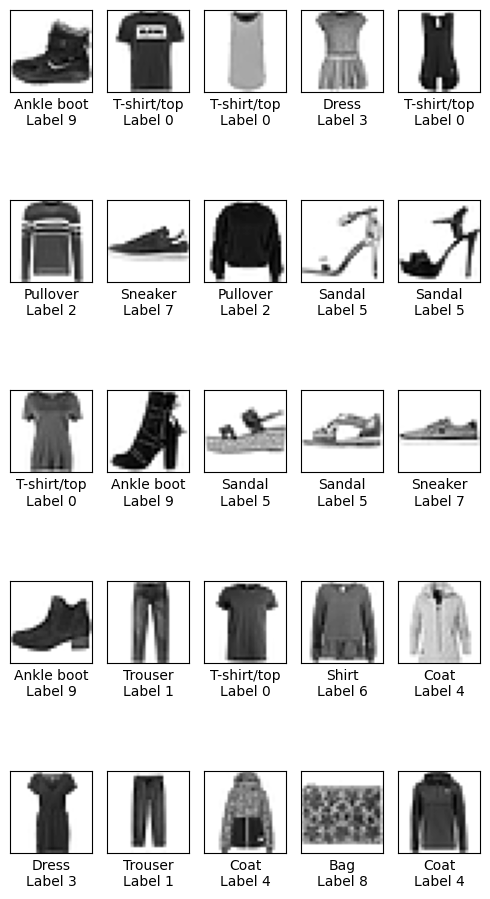

In [5]:
# Define class names
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Function to display images with labels
def show_images(images, labels, class_names, num=10):
    plt.figure(figsize=(5, 10))
    for i in range(num):  # Displaying the first num images
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(f"{class_names[labels[i]]}\nLabel {labels[i]}")
    plt.tight_layout()
    plt.show()

# Display images with labels
show_images(train_images, train_labels, class_names, num=25)

For simplicity sake we work with the first 2000 elements. It would be easier to visualize the data that way.

In [6]:
N = 2000
X = train_images[:N].reshape(-1, 28*28)
y = train_labels[:N]
print(X.shape, y.shape)

(2000, 784) (2000,)


## <font color='green'>1. Principal Component Analysis (PCA)</font>

We work with a set of N points in a D-dimensional space. In other words, our dataset is given by a $N \times D$ matrix $X$. We want to **reduce its dimension**.

Let us briefly recall **Principal Component Analysis (PCA)**.

1.   Assume that **the data is centered**. Otherwise, we subtract column means and make them equal to zero: $$\operatorname{mean}(X, \operatorname{axis}=0) = (0, 0, ..., 0).$$
2.  Take the $D \times D$ **covariance matrix** $$C =\frac{1}{n-1} X^T X.$$ Since $C$ is a symmetric matrix, there exist an orthogonal matrix $V$ and a diagonal matrix $\Lambda$ such that $$C = V \Lambda V^T.$$  The columns of $V$ are called **principal axes**. We assume that the values on the diagonal of $\Lambda$ are sorted in the descending order:$$\Lambda = \operatorname{diag}(\lambda_1, \dots, \lambda_D), \qquad \lambda_1 \geq \dots \geq \lambda_D.$$
3.  Finally, we can keep only **the first L principal components**. In other words, we take the projection of the data: $$X_{L}=X V_{L},$$ where $V_L$ is the $N \times L$ matrix consisting of the first $L$ columns of $V$. That is, the first column of $X_L$ is the projection of the data points onto the first principal component, the second column is the projection onto the second principal component, etc.


Below we use the [standard implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and visualize the result.



In [7]:
from sklearn.decomposition import PCA

# Apply PCA
n_components = 2  # You can adjust the number of components based on your visualization needs
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X)

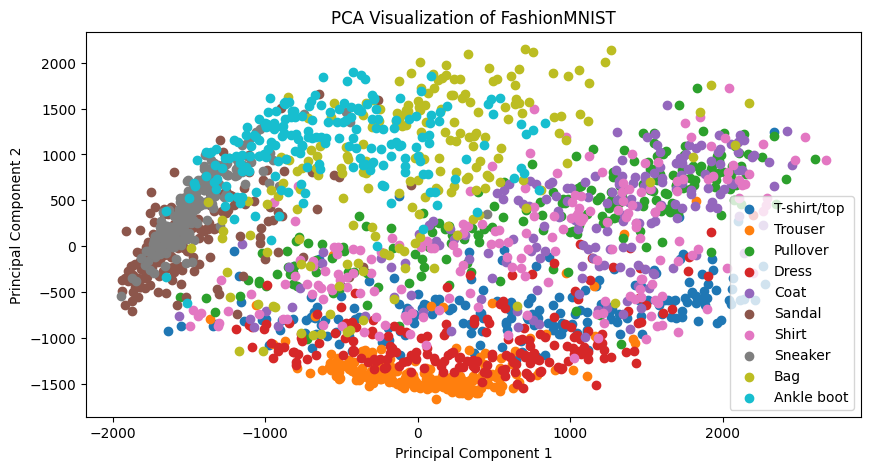

In [8]:
# Visualize the PCA result
def visualize_psa(X_pca, y_pca):
    plt.figure(figsize=(10, 5))
    for label in range(10):  # Assuming there are 10 classes in FashionMNIST
        plt.scatter(X_pca[y_pca == label, 0], X_pca[y_pca == label, 1], label=class_names[label])
    plt.title("PCA Visualization of FashionMNIST")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

visualize_psa(pca_result, y)


### 1.1.1 <font color='Green'>**Your task**</font> (3 points):

**Implement PCA** using <font color='blue'>SVD decomposition</font>.

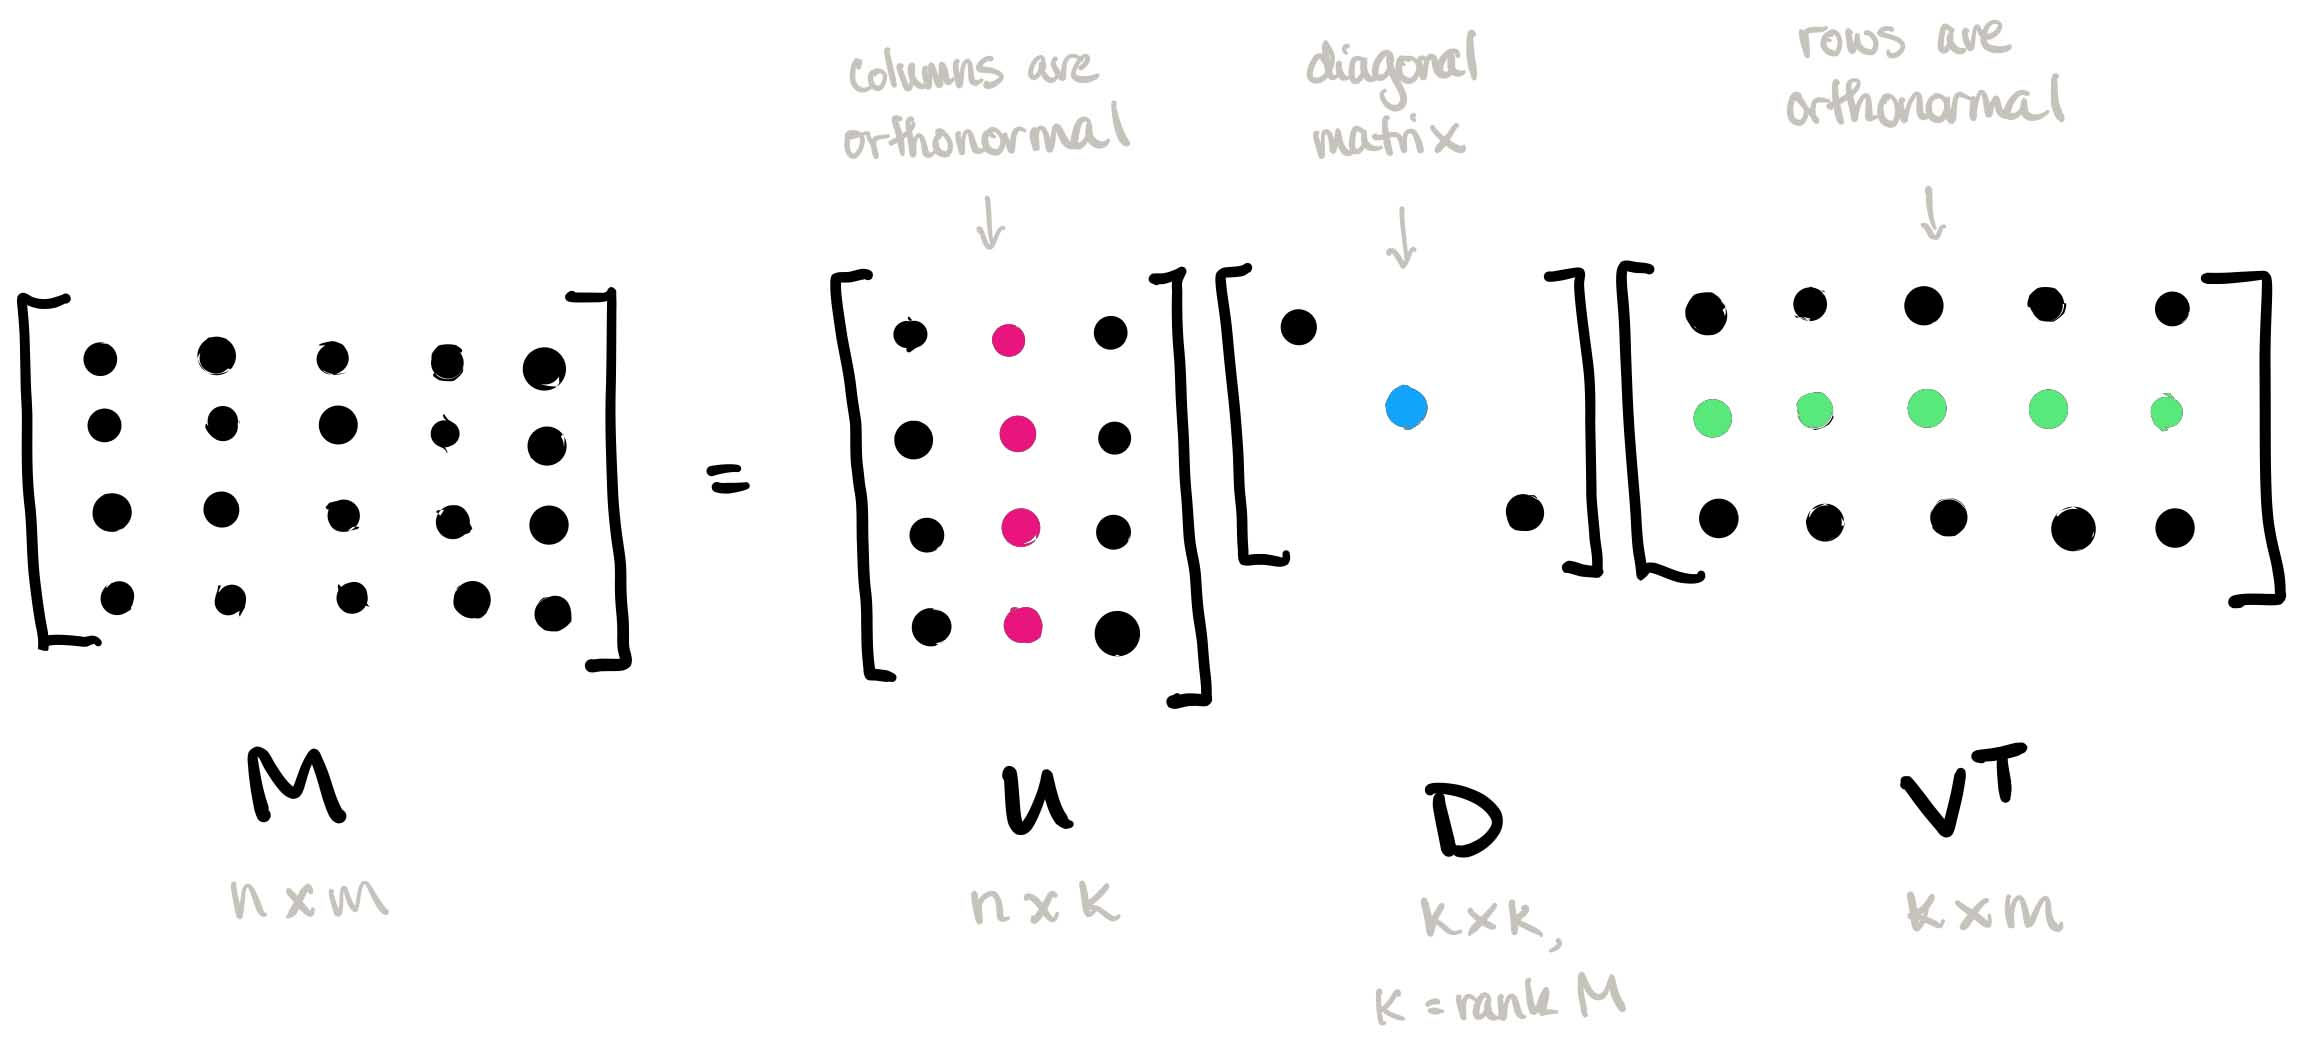


Complete the code below. **Only numpy is allowed**.  

In [9]:
def our_pca(X, n_components):
  """
  Perform PCA on a data matrix X using SVD.

  Args:
      X:  array, shape (N, D)
          A 2D numpy array representing the data matrix.

      n_components: The number of principal components to retain.

  Returns:
      X_reduced: array, shape (N, n_components)
                 The data matrix projected onto the principal components.
                 Its 1st column is the projection of X onto the 1st principal component,
                 the 2nd column is the projection onto the 2nd principal component, etc.
  """
  # Center the data
  X_centered = X - np.mean(X, axis=0)

  # Perform SVD
  U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

  # Select the top n_components principal components
  components = Vt[:n_components]

  # Project the data onto the principal components
  X_reduced = np.dot(X_centered, components.T)

  return X_reduced


The shape of X_reduced must be (N, n_components)

In [10]:
n_components = 2
our_pca_result = our_pca(X, n_components)
print(our_pca_result.shape)
assert our_pca_result.shape == (N, n_components)

(2000, 2)


If done correctly, you should get the same picture as above (maybe up to the signs for the axis, so the image can be mirrored).

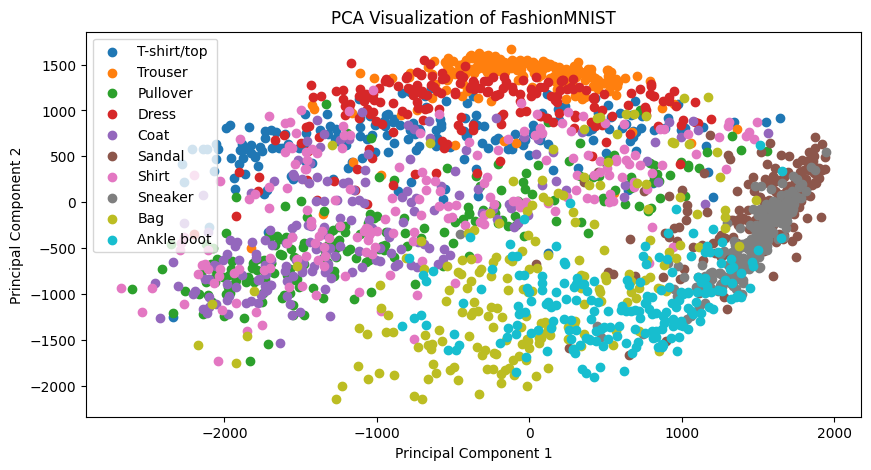

In [11]:
visualize_psa(our_pca_result, y)

# <font color='green'>2. Probabalistic PCA (PPCA) </font>

Now, let us discuss the probabilistic  analogue of PCA. Below we use notations and formulas from the lectures. You can also read about PPCA in Section 12.2 of Bishop's [Pattern Recognition and Machine Learning ](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

The data is given by a $N \times D$ matrix X. Let $\left\{x_i^T \right\}_{i=1}^N$ be the rows of X. Each $x_i$ is a lenght-D vector. In accordance with the lectures, we assume that the data is centered: $$\frac{1}{N} \sum_{i=1}^N x_i = \vec{0}.$$


In [12]:
# Centering the data
X = X - np.mean(X, axis=0)


We assume that $D$-dimensional observable variable $x_i$ is defined by a linear transformation of the $k$-dimensional latent variable $z$ plus additive Gaussian noise: $$x_i =z_i W^T +\varepsilon.$$ Here

*   $z_i$ is the $k$-dimensional latent variable;
*   $W$ is an   $D \times k$ matrix;
*   the noise is **isotropic**, i.e. $\varepsilon \sim \mathcal{N}(0,\sigma^2 I_k)$, where $I_k$ is the $k\times k$ identity matrix.

We assume that the distribution of the <font color='blue'>**latent variables**</font> and the conditional distribution of $x_i$ given $z_i$ are normal: $$p(z_i) = \mathcal{N}(z_i \bigr|O, I_k), \qquad p(x_i \bigr| z_i, W, \mu, \sigma^2) = \mathcal{N}(x_i \bigr|z_i W^T, \sigma^2 I_D). $$

## <font color='green'>2.1 Closed-form solution (3 points) </font>

The nice thing about PPCA is that it has an **exact closed-form solution**. Let us recall the formulas for the values $W_{ML}$ and $\sigma^2_{ML}$ that maximize the log-likelihood $\ln p(X | W, \sigma^2) = \sum_{i=1}^N \ln p(x_i | W, \sigma^2)$.  Take the data covariance matrix $$S = \frac{1}{N}\sum_{i=1}^N x_i^T x_i.$$ Since the matrix $S$ is symmetric, it can be diagonalized: $$ S = U L U^T,$$ where $$U \in O(D, \mathbb{R}), \quad L = \operatorname{diag} (\lambda_1, \dots, \lambda_D), \quad \lambda_1 \geq \dots \geq \lambda_D.$$

<font color='blue'> **Exact solution for $\sigma^2$:** </font>  $$\sigma^2_{ML} = \frac{1}{D-k} \sum_{j=k+1}^D \lambda_j. $$


<font color='blue'> **Exact solution for $W$:** </font>
 $$W_{ML} = U_{k} \left(L_k - \sigma_{ML}^2 I_{k} \right)^{1/2} R,$$ where

*   $U_k$ is the $D \times k$ matrix whose columns are given by the $k$ first columns of $U$.
*   $L_k = \operatorname{diag} (\lambda_1, \dots, \lambda_k)$ is the $k\times k$ diagonal matrix containing $k$ largest eigenvalues. (In the lectures $\lambda_j = \sigma^2_j$.)
*   $R$ is an arbitrary $k \times k$ orthogonal matrix (**We assume $R = I_{k}$**).



<font color='red'>**Your task**</font>. Implement this formulas.

In [13]:
def PPCA_Solution(X, k=50):
    """
    Exact closed-form solution for PPCA

    Parameters
    ----------
    X : array, shape (N, D)
        Given data.
    M:  integer
        Dimension of the latent space
    Returns
    -------
    W : array, shape (D, k)
        Linear transformation matrix.
    sigma^2 : float
        Estimate of standard deviation of Gaussian noise.
    """

    N, D = X.shape

    # Calculate the data covariance matrix S
    S = np.dot(X.T, X) / N

    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = sla.eigh(S)

    # Sort eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select the top k eigenvectors
    Uk = eigenvectors[:, :k]
    Lk = np.diag(eigenvalues[:k])

    # Calculate the exact solution for sigma^2
    sigma2 = np.sum(eigenvalues[k:]) / (D - k)

    # Calculate W
    W = np.dot(Uk, np.sqrt(Lk - sigma2 * np.eye(k)))

    return W, sigma2

Check the size of W

In [14]:
# Shape of X
N, D = X.shape
# The dimension of the latent space
K = 700
# Exact solution
W_ML, sigma2_ML = PPCA_Solution(X, k=K)
assert W_ML.shape == (D, K)

## <font color='green'>2.2 Sampling using PPCA (3 points) </font>



Let's see how well PPCA encodes our images. We take the first 10 images.


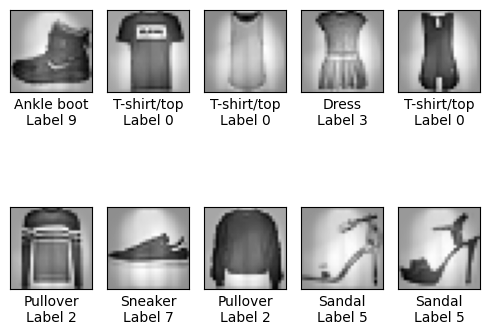

In [15]:
# Display images with labels
N_samples = 10
X10 = X[:N_samples, :]
show_images(X10.reshape(-1, 28, 28), train_labels[:N_samples], class_names, num=N_samples)

Luckily for us, the posterior distribution over latent variable is also Gaussian: $$p(z| x) = \mathcal{N} \left(z | m, V\right), \qquad m = x^T W M^{-1}, \qquad V = \sigma^{-2} M, $$ where $$M = W^T W + \sigma^2 I_{M}.$$

We "encode" the elements $x_i$ with the mean of the posterior distribution $\mathbb{E}[z|x_i] = m $.

<font color='red'>**Your task**</font>. Calculate the latent variables $z_i = \mathbb{E}[z|x_i]$ for the first 10 images.

In [16]:
def PPCA_Encode(X, W, sigma2):
    """
    Exact closed-form solution for PPCA

    Parameters
    ----------
    X : array, shape (N, D)
        Given data.
    W : array, shape (D, k)
        Linear transformation matrix.
    sigma^2 : float
        Estimate of standard deviation of Gaussian noise.
    Returns
    -------
    Z : array, shape (N, D)
        Mean of the posterior distribution
    """
    Z = np.dot(X, W) @ np.linalg.inv(W.T @ W + sigma2 * np.eye(W.shape[1]))

    return Z

Calculate latent variables

In [17]:
Z10 = PPCA_Encode(X10, W_ML, sigma2_ML)
assert Z10.shape == (N_samples, K)

Let's generate some images

In [18]:
def generate_images(Z, W, sigma2):
    """
    Samples an image form the p(X | Z, W, sigma^2) distribution

    Parameters
    ----------
    Z : array, shape (N_samples, k)
        Latent variables.
    W : array, shape (D, k)
        Linear transformation matrix.
    sigma^2 : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    Img: array, shape (N_samples, D)
         Sampled images
    """
    gen_images = []
    for i in range(N_samples):
        m = W @ Z[i,:]
        cov = sigma2**(-1) * np.eye(W.shape[0])
        gen_images.append(np.random.multivariate_normal(m, cov))
    return np.stack(gen_images, axis=0)

You should see "noisy" reconstructions of the originals.

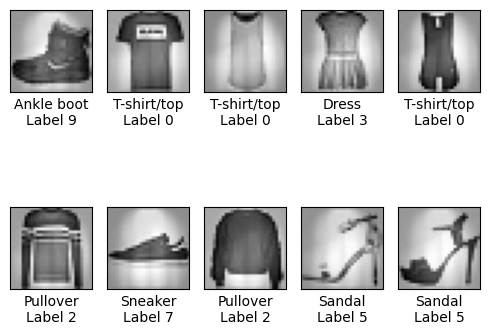

In [19]:
gen_images = generate_images(Z10, W_ML, sigma2_ML)
show_images(gen_images.reshape(-1, 28, 28), train_labels[:N_samples], class_names, num=N_samples)

##  <font color='green'>2.3 EM algorithm </font>


In the PPCA we don't know:

1.   the latent varibables $z_i$;
2.   the parameters $W, \mu, \sigma^2$. For short, we denote them as $$ \theta = (W, \mu, \sigma^2).$$

We can search for $z_i$ and $\theta$ using the EM algorithm. This is a 2-step procedure:


*   On the <font color='blue'>**E-step**</font> we <font color='red'>estimate the distribution</font>  on $z_i$ given $x_i$ and $\theta$. The posterior distribution $p(z_i | x, \theta_i)$ is Gaussian with parameters $$\mathbb{E}[z_i] = x_i W M^{-1}, \\ \mathbb{E}[z_i^T z_i] = \sigma^2 M^{-1} + \mathbb{E}[z_i]^T\mathbb{E}[z_i],  $$ where $$M = W^T W + \sigma^2 I_{M}.$$

*   On the <font color='blue'>**M-step**</font> we find the parameters $\theta = (W, \mu, \sigma^2)$ given $x_i$ and $z_i$. We <font color='red'>maximize the likelihood</font> : $$W_{new} = \left[\sum_{i=1}^N  x_i^T \mathbb{E}[z_i]  \right]\left[\sum_{i=1}^N \mathbb{E}[z_i^Tz_i] \right]^{-1}, \\ \sigma^2_{new} = \frac{1}{ND}\sum_{i=1}^N \left(\left\|x_i \right\|^2 - 2 x_i W_{new} \mathbb{E}[z_i]^T   + \operatorname{tr} \left(W_{new}^T W_{new} \mathbb{E}[z_i^T z_i]  \right) \right).$$





### <font color='green'>2.3.1 Simplify the formulas (2 points)  </font>

Consider the data covariance matrix $$S = \frac{1}{N} \sum_{i=1}^N x_i^T x_i.$$ In the EM algorithm we switch between the E-step and then the M-step.


 <font color='green'>**Your task**.</font>  Simplify the formulas for $W_{new}$ and $\sigma^2_{new}$ in terms of $S$ and $W$.

*   The formula for $W_{new}$ should contain only $\sigma^2$, the matrices $M$, $W$ and $S$.
*   The formula for $\sigma^2_{new}$ should contain only $D$, the matrices $M$, $W$, $S$ and $W_{new}$.


$$W_{new} = \left[\sum_{i=1}^N  x_i^T \mathbb{E}[z_i]  \right]\left[\sum_{i=1}^N \mathbb{E}[z_i^Tz_i] \right]^{-1}= \left[\sum_{i=1}^N  x_i^T x_i W M^{-1}
 \right]\left[\sum_{i=1}^N \sigma^2 M^{-1} + \mathbb{E}[z_i]^T\mathbb{E}[z_i] \right]^{-1}=\\ NSWM^{-1}\left[\sum_{i=1}^N \sigma^2 M^{-1} + \sum_{i=1}^N\mathbb{E}[z_i]^T\mathbb{E}[z_i] \right]^{-1}=\\ NSWM^{-1}\left[N \sigma^2 M^{-1} + \sum_{i=1}^N[x_i W M^{-1}]^Tx_i W M^{-1} \right]^{-1}=\\ SWNM^{-1}\left[\left[\sigma^2 I + [W M^{-1}]^T S W\right]NM^{-1}\right]^{-1}= SW\left[\sigma^2 I +(M^{-1})^TW^T S W\right]^{-1}$$
 <br>
 $$ \sigma^2_{new} = \frac{1}{ND}\sum_{i=1}^N \left(\left\|x_i \right\|^2 - 2 x_i W_{new} \mathbb{E}[z_i]^T   + \operatorname{tr} \left(W_{new}^T W_{new} \mathbb{E}[z_i^T z_i]  \right) \right)=\\ \frac{1}{ND}\sum_{i=1}^N \left\|x_i \right\|^2 - \frac{2}{ND}\sum_{i=1}^N x_i W_{new} [x_i W M^{-1}]^T   +\\ \frac{1}{ND}\sum_{i=1}^N\operatorname{tr} \left(W_{new}^T W_{new} [σ^2 M^{-1} +[x_i W M^{-1}]^Tx_i W M^{-1}  \right)=\\
  \frac{\operatorname{tr}\left(S\right)}{D} - \frac{2}{ND}\sum_{i=1}^N \operatorname{tr}\left(x_i W_{new}(M^{-1})^T W^T  x_i^T\right) +\\ \frac{1}{D}\operatorname{tr} \left(W_{new}^T W_{new} (σ^2 M^{-1} +(M^{-1})^TW^TS W M^{-1})  \right)=\\
  \frac{\operatorname{tr}\left(S\right)}{D} - \frac{2}{ND}\sum_{i=1}^N \operatorname{tr}\left(x_i^T x_i W_{new}(M^{-1})^T W^T  \right) + \frac{1}{D}\operatorname{tr} \left(W_{new}^T W_{new} W_{new}^{-1}SW M^{-1})  \right)=\\
 \frac{1}{D}\left(\operatorname{tr}\left(S - 2S  W_{new}(M^{-1})^T W^T \right)+\operatorname{tr}\left( W_{new}^T SW M^{-1})\right)\right)
$$
<br><br>
$$W_{new} =SW\left[\sigma^2 I +(M^{-1})^TW^T S W\right]^{-1}   \qquad \sigma^2_{new} = \frac{1}{D}\left(\operatorname{tr}\left(S - 2S  W_{new}(M^{-1})^T W^T \right)+\operatorname{tr}\left( W_{new}^T SW M^{-1})\right)\right) $$





In [20]:
#Write the formulas


### <font color='green'>2.3.2 Implementation of EM algorithm for PPCA (4 points)  </font>



 <font color='red'>**Your task**.</font>  Complete the code below.


In [25]:
def PPCA_EM(X, K_dim, max_iter=20):
    """
    Solution for PPCA using EM algorithm

    Parameters
    ----------
    X : array, shape (N, D)
        Given data.
    K_dim:  integer
        Dimension of the latent space
    max_iter: integer
        Maximal number of iterations

    Returns
    -------
    W : array, shape (D, k)
        Linear transformation matrix.
    sigma^2 : float
        Estimate of standard deviation of Gaussian noise.
    """
    N, D = X.shape

    # Initialize parameters randomly
    W = np.random.randn(D, K_dim)
    sigma2 = 1.0

    # E-step: Compute the posterior mean of latent variables
    def E_step(X, W, sigma2):
        return W.T @ W + sigma2 * np.eye(K_dim)

    # M-step: Update W and sigma^2
    def M_step(X, W):
        S = X.T @ X / N
        W_new = S @ W @ np.linalg.inv(sigma2 * np.eye(K_dim) + np.linalg.inv(M).T @ W.T @ S @ W)
        sigma2_new = (1/D)*(np.trace(S - 2*S @ W_new @ np.linalg.inv(M).T @ W.T) + np.trace(W_new.T @ S @ W @ np.linalg.inv(M)))
        return W_new, sigma2_new

    # EM iterations
    for i in range(max_iter):
        # E-step
        M = E_step(X, W, sigma2)

        # M-step
        W_new, sigma2_new = M_step(X, W)

        # Update parameters
        W = W_new
        sigma2 = sigma2_new

    return W, sigma2

Apply the function

In [26]:
K_dim = 600
W_EM, sigma2_EM = PPCA_EM(X, K_dim=K_dim, max_iter=50)
assert W_EM.shape == (X.shape[1], K_dim)

Let's generate some images

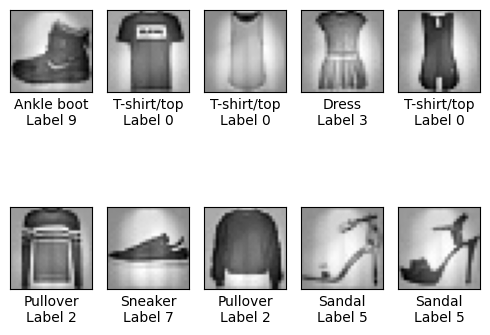

In [27]:
Z10_EM = PPCA_Encode(X10, W_EM, sigma2_EM)
assert Z10_EM.shape == (N_samples, K_dim)

gen_images_EM = generate_images(Z10_EM, W_EM, sigma2_EM)
show_images(gen_images_EM.reshape(-1, 28, 28), train_labels[:N_samples], class_names, num=N_samples)

# <font color='green'>3. Variational Autoencoder (VAE). </font> Optional Task.

You may not be impressed with PCA or PPCA. Below we train a very simple, yet quite effective generative model: <font color='blue'>Variational Autoencoder (VAE). </font>

The idea is simple. VAE consists of 2 neural networks:

1.   **Encoder** E(x). It maps the data to the latent space. Namely, it learn the parameters of a Gaussian distribution $p(z)$.  
2.   **Decoder** D(z). It reconstructes the data from a latent vector $z$ sampled  from the Gaussian distribution $z \sim p(z)$.

Roughly speaking, we train VAE so that $D(E(x)) \approx x$.

 <font color='red'>**Your task**. </font> VAE has been written below. You can take a look at the code and then **sample** some images. The task is at the end of the HW.

We construct and train neural networks using PyTorch (https://pytorch.org/). We refer to their tutorial https://pytorch.org/tutorials/ for technical details.

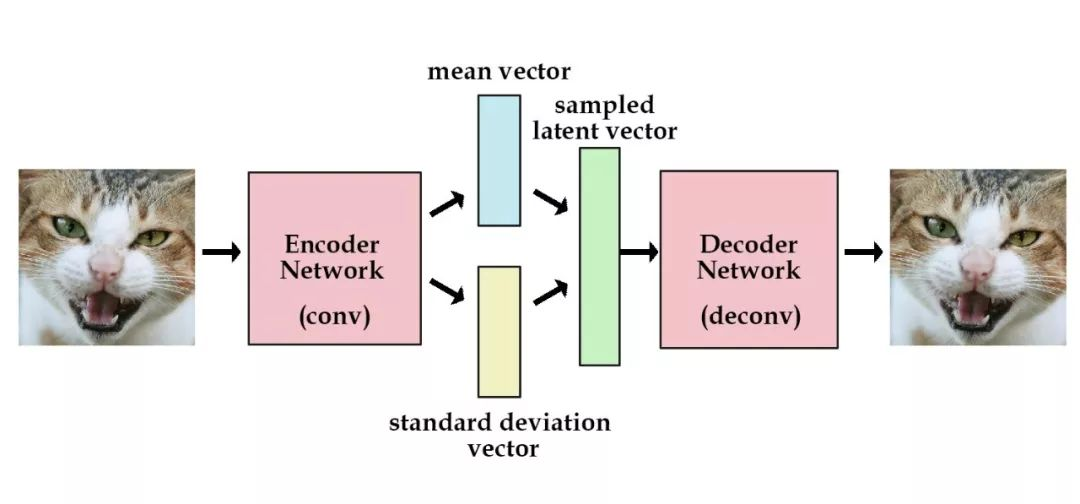

## 3.1 <font color='green'> Import of basic libraries </font>  

In [ ]:
# For the creation and training of neural networks
import torch
from torch import nn, optim
import torch.nn.functional as F

# To download datasets
from torch.utils.data import Dataset, DataLoader

# For data processing
import torchvision
import torchvision.transforms as TF
from torchvision.utils import make_grid # For displaying a set of images
from torchvision.utils import save_image

from IPython import display
from IPython.display import clear_output
from tqdm.auto import tqdm # to display the learning progress on the screen

Check the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# <font color='green'>3.2 Data preprocessing</font>  

Load FashionMNIST dataset

In [ ]:
from keras.datasets import fashion_mnist
# Load FashionMNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = torch.tensor(train_images.reshape(-1, 28 * 28))
test_images = torch.tensor(test_images.reshape(-1, 28 * 28))
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

In order to load images, create an object of the **Dataloader** class. Instruction https://pytorch.org/vision/stable/datasets.html

We specify:

*   *Dataset* that contains the data
*   *Batch_size* = how many images to take at a time
*   *Shuffle* = do we need to shuffle the data
*   *Num_workers* =  how many parallel processes to create (usually the number of cores in the processor)


In [ ]:
from torch.utils.data import Dataset

# Define a custom dataset class
class MyDataset(Dataset):
  def __init__(self, data,  labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx].float() / 255, self.labels[idx]

BATCH_SIZE = 32

train_dataset = MyDataset(train_images, train_labels)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataset = MyDataset(test_images, test_labels)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# <font color='green'>3.3 VAE</font>   


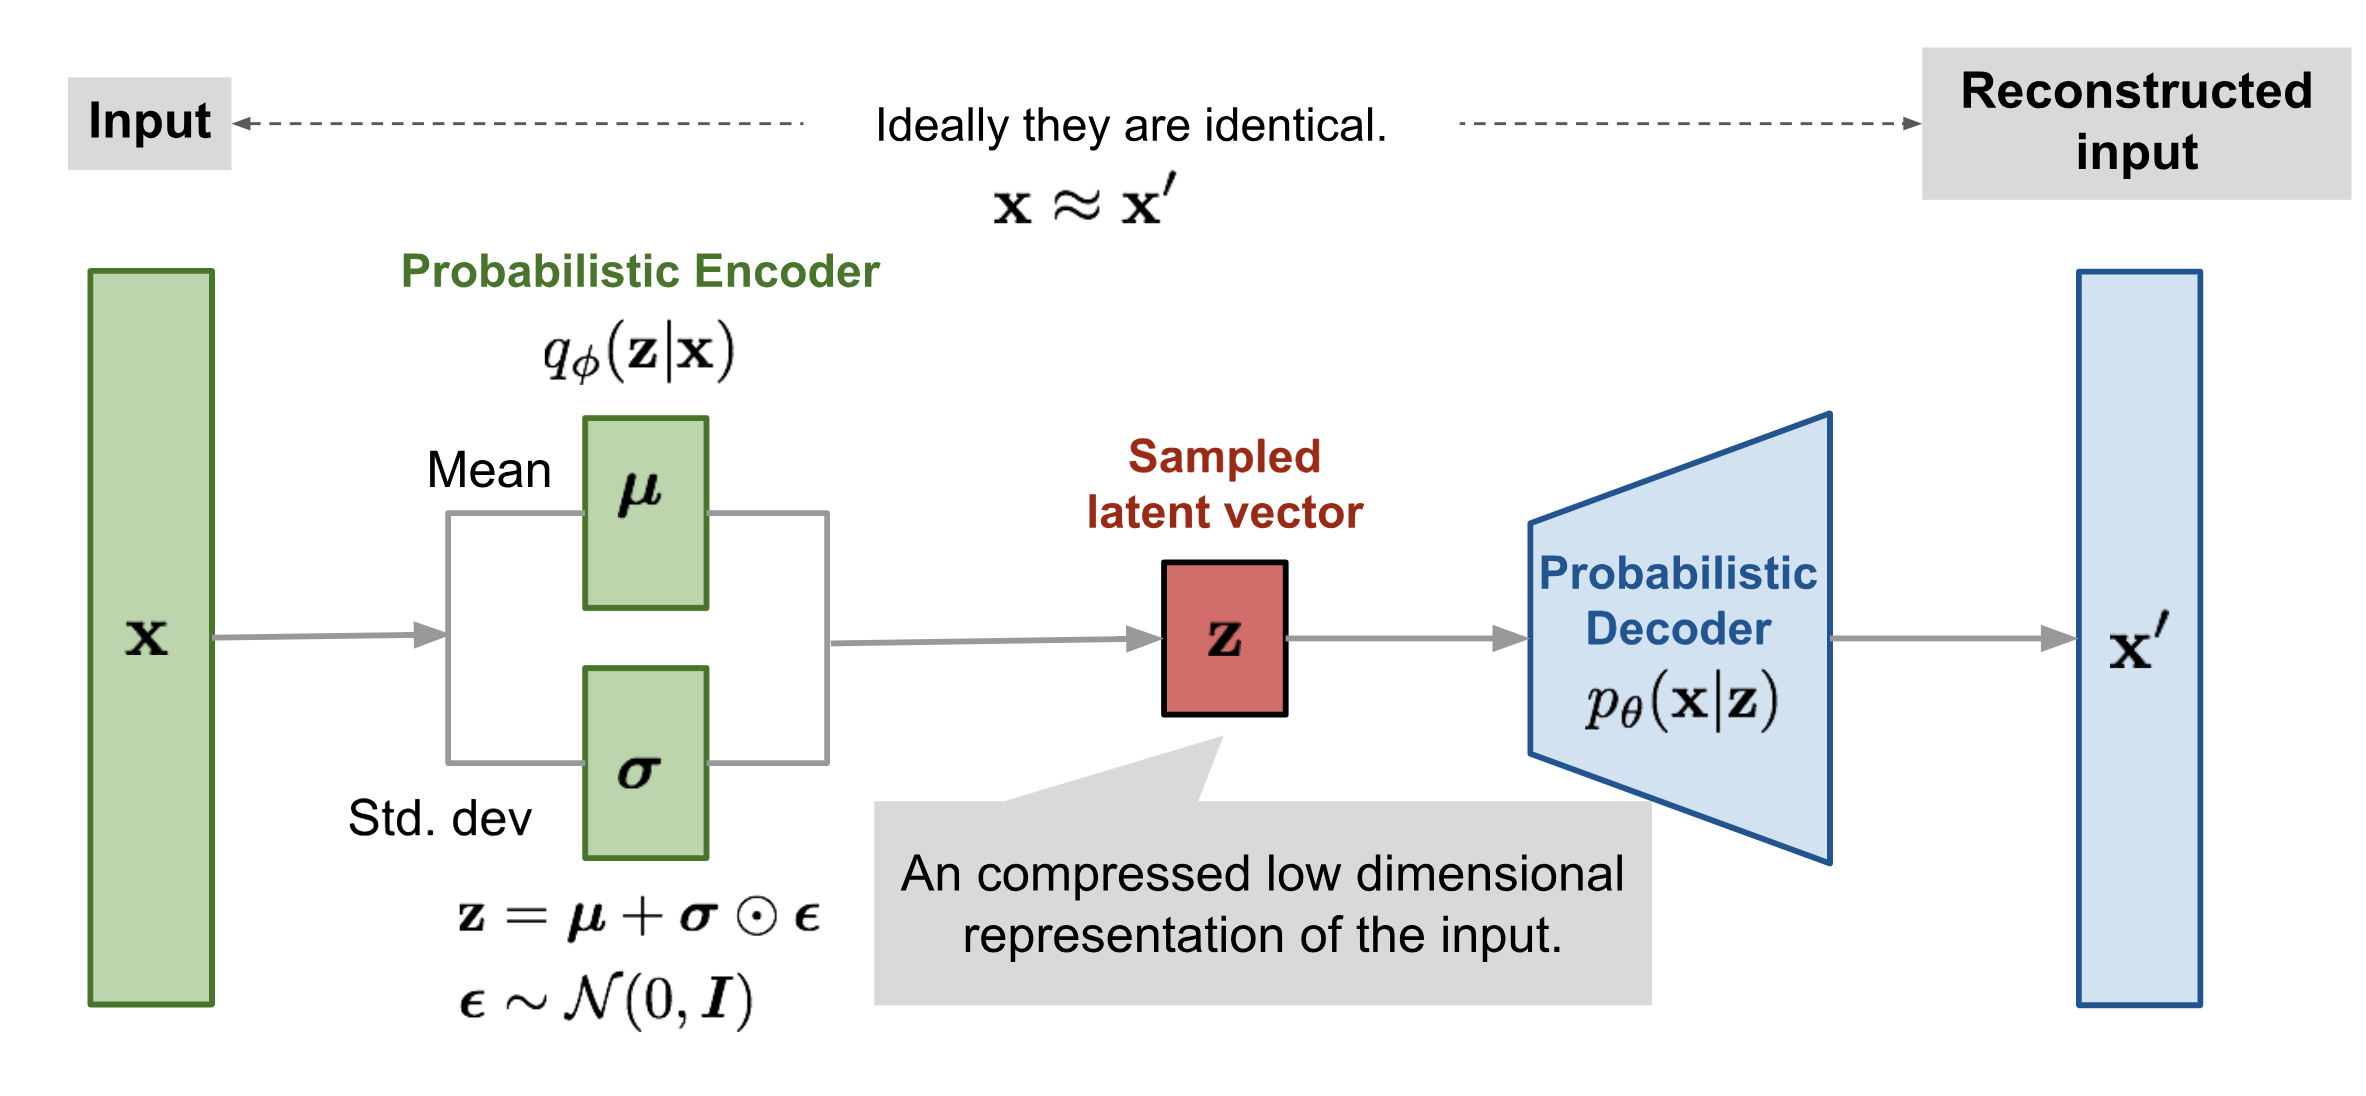

One can consider a wide variety of encoders and decoders.

One of the simplest options is to take a pair of MLPs, as shown in the diagram below.



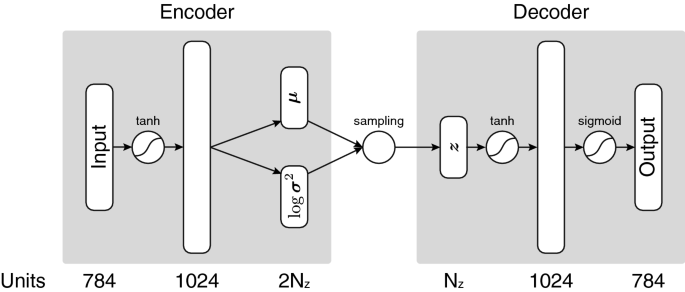

# **Remark**

1.   The sizes of the layers, latent space, activation functions, and architecture can be changed.
2.   For simplicity, we **sample only one z**.
3.   The decoder predicts *an object, not a probability*.
4.   The encoder predicts  <font color='red'>logsigma, not sigma.  </font>.


The variance σ² > 0. This is a positive function, its derivative at zero is equal to 0. For stability of training, it is better to predict a real number, not a positive one.

## <font color='green'>3.4 Creating VAE </font>   

In [ ]:
# dimension of latent space
dimZ = 100

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        hid_dim = 1024
        self.fc1 = nn.Linear(784, hid_dim)
        self.fc21 = nn.Linear(hid_dim, dimZ)
        self.fc22 = nn.Linear(hid_dim, dimZ)
        self.fc3 = nn.Linear(dimZ, hid_dim)
        self.fc4 = nn.Linear(hid_dim, 784)

    def encode(self, x):
        h1 = torch.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## <font color='green'>3.5 Training of Neural Network</font>  

### <font color='green'>3.5.1 Loss function </font>  

Our aim is to **minimize** the following loss:

$$\mathcal{L} = -\log p_{\theta}(x|z) +
\operatorname{KL}(q_{\phi}(z|x)||p(z))  \to \min$$

*   For the 1st term (the likelihood) we will take the cross-entropy.
*   The 2nd term is the KL-divergence:
$$\operatorname{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$



Don't forget the encoder predicts  <font color='red'> logsimga, not sigma </font>.

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  <font color='green'>3.5.2 Training function </font>  


In [ ]:
def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for iteration, (batch, _) in tqdm(enumerate(loader)):
        batch = batch.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(batch)
        loss = criterion(batch, reconstruction, mu, logvar)
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for iteration, (batch, _) in tqdm(enumerate(loader)):
          batch = batch.to(device)
          reconstruction, mu, logvar = model(batch)
          loss = criterion(batch, reconstruction, mu, logvar)
          losses_val.append(loss.item())
    return np.mean(losses_val)

In [ ]:
def learning_loop(model, optimizer, train_loader, val_loader, criterion, epochs=10,
                  val_every=1, draw_every=1, separate_show=False):

    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        # Validate and save the loss every val_every epochs
        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)

        # Plot a graph every draw_every steps
        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.show()

    return model, optimizer, losses

###  <font color='green'>3.5.3 Process of Learning</font>  

In [ ]:
vae = VAE().to(device)
criterion = loss_function
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 10 # YOU CAN CHANGE THIS NUMBER

In [ ]:
vae, optimizer, losses = learning_loop(
    model = vae,
    optimizer = optimizer,
    train_loader = dataloader,
    val_loader = testloader,
    criterion =  criterion,
    epochs = num_epochs,
  )

# <font color='green'>3.6 Checking the result</font>

In [ ]:
from itertools import islice

Loading images

In [ ]:
images, _ = list(islice(testloader, 1))[0]
# Reshape each image to 28x28
images_reshaped = images.reshape(-1, 28, 28)

# Create a grid of subplots
n_rows, n_cols = 4, 4  # Adjust as needed for your number of images
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))  # Adjust figsize for desired size

# Enumerate over images and plot them
for i, ax in enumerate(axes.flat):
  if i >= len(images_reshaped):  # Ensure we don't plot beyond available images
    break
  ax.imshow(images_reshaped[i], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f"Image {i+1}")

# Tight_layout for better spacing and prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

Application of VAE

In [ ]:
reconstruction, mu, logsigma = vae(images.to(device))
reconstruction = reconstruction.cpu()
reconstruction = reconstruction.view(-1, 1, 28, 28)
plt.imshow(make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))
plt.show()

# <font color='blue'>3.7 Sampling (3 points) </font>

 <font color='red'>**Your task**. </font> Sample and draw 25 pictures using the decoder.

In [ ]:
# Generate random latent vectors
num_samples = 25
random_latent_vectors = torch.randn(num_samples, dimZ).to(device)

# Pass latent vectors through the decoder
with torch.no_grad():
    decoded_images = vae.decode(random_latent_vectors)

# Reshape and plot the generated images
decoded_images = decoded_images.cpu().view(-1, 1, 28, 28)
plt.figure(figsize=(6,6))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
